# A minimal logic example

This example takes an input value and performs an exclusive or with the value `0xaa`, or the bit sequence `10101010` (MSB first).

Gate level display of `XOR` combinatorial logic (**not generated**!)
![XOR gate](https://www.electronicshub.org/wp-content/uploads/2015/07/exor-equivalent-circuit.jpg)

## Design stage

Let's write some simple code:

In [1]:
from myhdl import *

@block
def test(clk, a, b):
    @always_comb
    def xor_assign():
        b.next = a ^ 0xaa

    return instances()

### Question

What's missing in the above design?

## Translation stage

Translate source to the 'RTL' internal language.

In [2]:
from myhdl.conversion import yshelper

def convert():
    # Create top level signal instances:
    clk = Signal(bool())
    v, q = [ Signal(intbv()[8:]) for i in range(2) ]

    # Create a yosys design:
    design = yshelper.Design("test")
    inst = test(clk, v, q)
    inst.convert("yosys_module", design, name="test", trace=True)
    return design
design = convert()

CREATE Module: 'test'
Adding module with name: test_1_8_8
CONVERT_RTL tree >>>>>> 'TEST_XOR_ASSIGN' 
DONE instancing submodules


### RTL display

To display the synthesized logic circuit, we convert the design to a SVG image. By default, this displays the top level module circuits.

Generating RTL image...
Display...


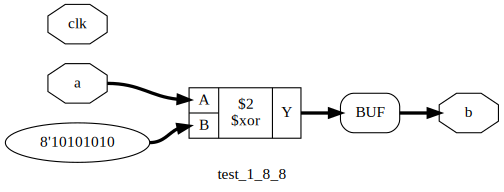

In [3]:
import config
from ys_aux import to_svg

display(to_svg(design, "", 75))

In [4]:
from myhdl import *

@block
def test(clk, a, b):
    @always_comb
    def xor_assign():
        b.next = a ^ 0xaa

    return instances()

design = convert()

CREATE Module: 'test'
Adding module with name: test_1_8_8
CONVERT_RTL tree >>>>>> 'TEST_XOR_ASSIGN' 
DONE instancing submodules


## Verifying behaviour

We create a testbench unit that stimulates the `test` block instance:

In [2]:
@block
def testbench():
    clk = Signal(bool())
    a, b, z = [ Signal(intbv(0xff)[8:]) for i in range(3) ]
    # Create instance of unit under test:
    uut = test(clk, a, b)

    @instance
    def stimulus():
        VALUES = [ 0xaa, 0xab, 0x55, 0x00, 0x00 ]
        yield (clk.posedge)
        yield (clk.posedge)
        print("a  b")
        for v in VALUES:
            yield clk.negedge
            a.next = v
            z.next = a
            yield clk.posedge
            print(z, b)
        yield clk.posedge
        raise StopSimulation

    @always(delay(10))
    def clkgen():
        clk.next = not clk
      
    return instances()

NameError: name 'block' is not defined

## Run the test bench

Remove trace files:

In [1]:
! rm -f *.vcd

In [ ]:
tb = testbench()

tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True, tracebackup=False)
tb.run_sim()
tb.quit_sim() # Quit so we can run another one

### Compare to VHDL/Verilog

Convert the `test` unit to V*:

1. Create signal top level instances

In [5]:
clk = Signal(bool())
v, q = [ Signal(intbv()[8:]) for i in range(2) ]

2. Instance the design unit:

In [6]:
instance = test(clk, v, q)
instance.convert("vhdl")

/home/pyosys/.local/lib/python3.7/site-packages/myhdl-0.11-py3.7.egg/myhdl/conversion/_toVHDL.py:408: ToVHDLWarning: Port is not used: clk
  category=ToVHDLWarning


We observe this has created a few VHDL files:

In [7]:
!ls *.vhd

pck_myhdl_011.vhd  test.vhd


Dump the VHDL design output file:

In [8]:
! grep "\S" test.vhd

-- File: test.vhd
-- Generated by MyHDL 0.11
-- Date: Wed Feb 10 09:40:03 2021
library IEEE;
use IEEE.std_logic_1164.all;
use IEEE.numeric_std.all;
use std.textio.all;
use work.pck_myhdl_011.all;
entity test is
    port (
        clk: in std_logic;
        a: in unsigned(7 downto 0);
        b: out unsigned(7 downto 0)
    );
end entity test;
architecture MyHDL of test is
begin
b <= (a xor to_unsigned(170, 8));
end architecture MyHDL;


### Exercise: Going synchronous

Questions:

* What would the logical behaviour be when making use of the `clk` signal?
* What is expected to be generated?

Fix up the [example](#Design-stage) by introducing a synchronous process decorator `@always(clk.posedge)`


### Next: [synchronous XOR](sync_logic.ipynb)